In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


In [24]:
# Sample dataset - replace with your own
df = pd.read_csv("customer_data.csv")  # Use an actual churn/segmentation dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [25]:
from sklearn.preprocessing import StandardScaler

# Drop irrelevant columns
df.drop(['customerID'], axis=1, inplace=True, errors='ignore')

df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df = df.dropna()


# Fill missing values with column means
df.fillna(df.mean(numeric_only=True), inplace=True)

# Select numeric features present in the data
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Standardize numeric features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[num_features])

# Create a new DataFrame with scaled features
df_scaled_df = pd.DataFrame(df_scaled, columns=num_features)

# Add the churn column back
df_scaled_df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0}).values


Text(0.5, 1.0, 'Churn Distribution')

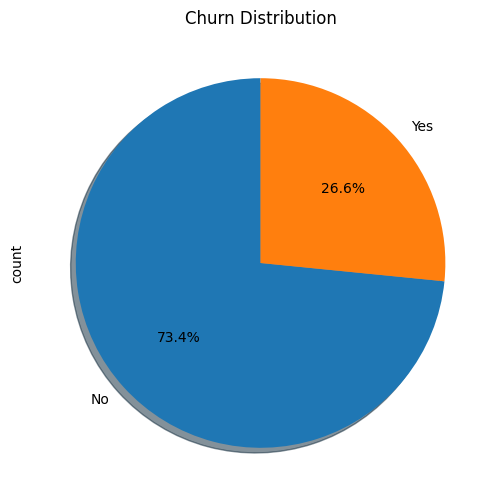

In [26]:
plt.figure(figsize=(6,6))
df['Churn'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, shadow=True, labels=['No', 'Yes'])
plt.title("Churn Distribution")


Text(0.5, 1.0, 'Churn by Contract Type')

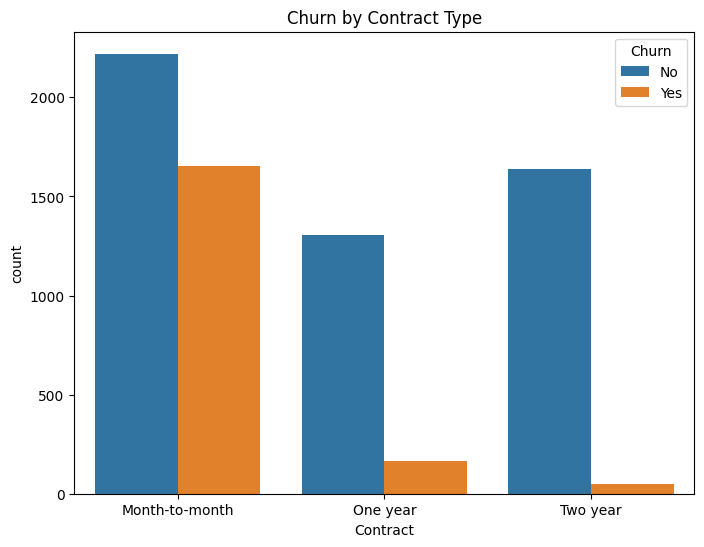

In [27]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title("Churn by Contract Type")


Text(0, 0.5, 'Inertia')

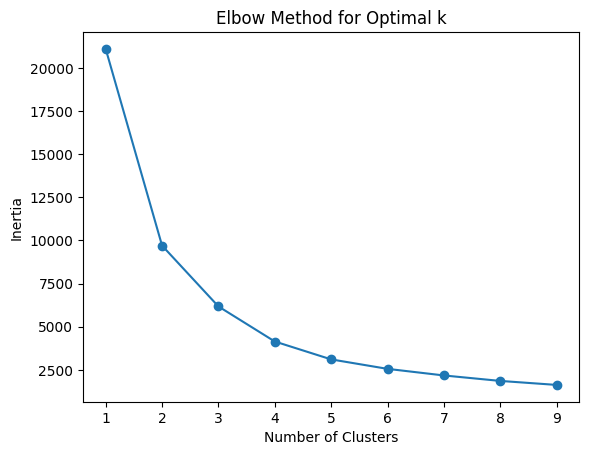

In [28]:
X_kmeans = df[['MonthlyCharges', 'TotalCharges', 'tenure']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kmeans)

distortions = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, 10), distortions, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')


Text(0.5, 1.0, 'Customer Segments based on Charges')

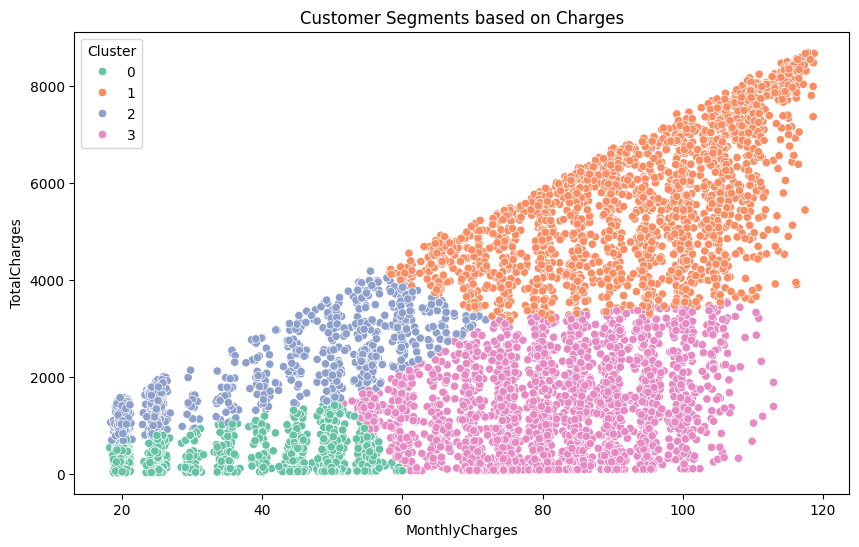

In [29]:
kmeans = KMeans(n_clusters=4, random_state=42)
X_kmeans['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=X_kmeans, x='MonthlyCharges', y='TotalCharges', hue='Cluster', palette='Set2')
plt.title("Customer Segments based on Charges")


In [34]:
df_clean = pd.read_csv("customer_data.csv")  # Reload fresh
df_clean['TotalCharges'] = df_clean['TotalCharges'].replace(" ", np.nan).astype(float)
df_clean = df_clean.dropna()
df_clean = df_clean.drop(columns=['customerID'])

df_encoded = pd.get_dummies(df_clean, drop_first=True)

X = df_encoded.drop('Churn_Yes', axis=1)
y = df_encoded['Churn_Yes']

# Standardizing numerical features
scaler = StandardScaler()
X[X.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [35]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [36]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8038379530916845
[[917 116]
 [160 214]]
              precision    recall  f1-score   support

       False       0.85      0.89      0.87      1033
        True       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



AUC Score: 0.8360507011922078


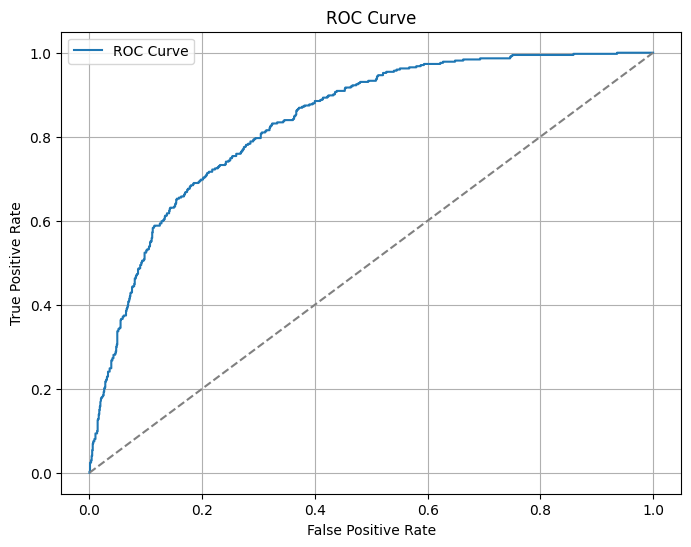

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.legend()
print("AUC Score:", roc_auc_score(y_test, y_proba))

Text(0.5, 1.0, 'Feature Importance (Logistic Regression Coefficients)')

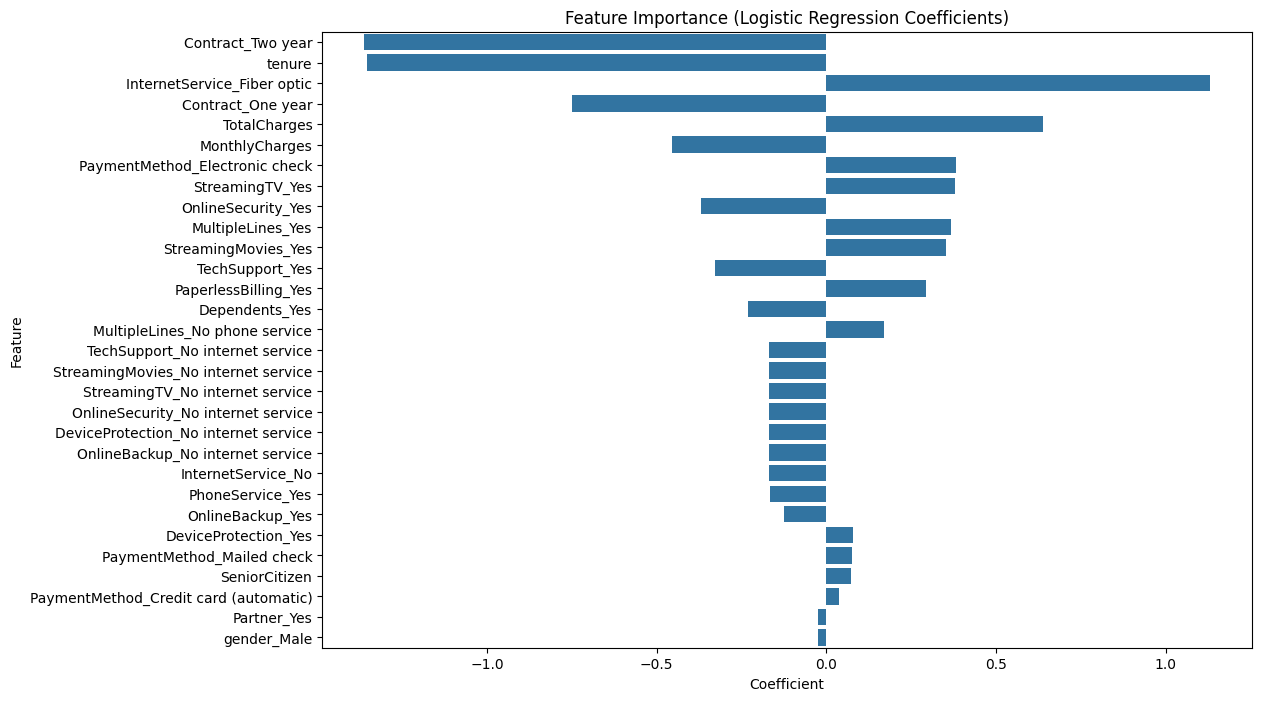

In [38]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=importance_df)
plt.title("Feature Importance (Logistic Regression Coefficients)")
